In [1]:
!pip install livelossplot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import he_normal

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [4]:
train_data_dir="/kaggle/input/courserafacemoreco/train/"
validation_data_dir="/kaggle/input/courserafacemoreco/test/"

In [5]:
num_classes = 0
for expression in os.listdir(train_data_dir):
    print(str(len(os.listdir(train_data_dir+expression)))+" "+expression +" images")
    num_classes += 1
print(num_classes)

3171 surprise images
3995 angry images
7214 happy images
4830 sad images
4965 neutral images
5


In [6]:
img_rows, img_cols = 48, 48
# img_size = 48 # old
img_size = 48 
batch_size = 64 # or 32



# datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True) # old
datagen_train = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = datagen_train.flow_from_directory(train_data_dir,
                                                    # target_size=(img_size,img_size), # old
                                                    target_size=(img_rows,img_cols),
                                                    color_mode='grayscale', # old
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True) # old
datagen_validation = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(validation_data_dir,
                                                              # target_size=(img_size,img_size), # old
                                                              target_size=(img_rows,img_cols),
                                                              color_mode='grayscale', # old
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 24175 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


In [7]:
print(train_generator.n)
print(validation_generator.n)

24175
6043


In [8]:
model = Sequential()

In [9]:
# Block-1

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

In [10]:
# Block-2

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

In [11]:
# Block-3

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

In [12]:
# Block-4

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

In [13]:
# Block-5

model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

In [14]:
# Block-6

model.add(Dense(64, kernel_initializer='he_normal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

In [15]:
# Block-7

model.add(Dense(num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

In [16]:
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [17]:
%%time

epochs = 200

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=4,
                              min_lr=0.00001,
                              verbose=1, #me
                              mode='auto')


checkpoint = ModelCheckpoint("CNNEmoDetLittleVgg_weights.h5",
                             monitor='val_loss',
                             save_best_only=True,#me
                             save_weights_only=True,
                             mode='min',
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=14,
                          verbose=1,
                          restore_best_weights=True)


callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr, earlystop]

CPU times: user 1.62 ms, sys: 895 µs, total: 2.51 ms
Wall time: 1.85 ms


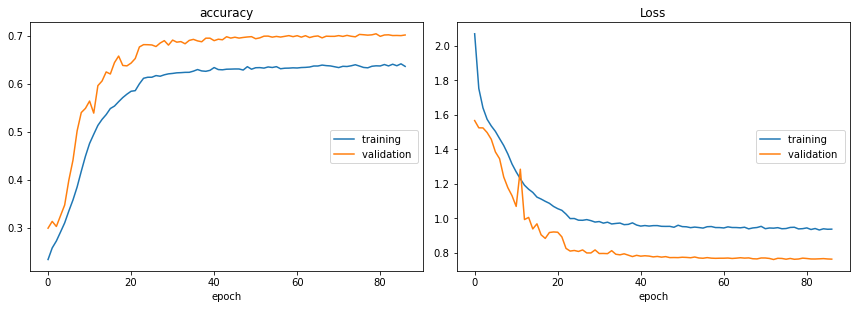

accuracy
	training         	 (min:    0.234, max:    0.642, cur:    0.636)
	validation       	 (min:    0.299, max:    0.704, cur:    0.702)
Loss
	training         	 (min:    0.931, max:    2.069, cur:    0.936)
	validation       	 (min:    0.760, max:    1.566, cur:    0.762)

Epoch 00087: val_loss did not improve from 0.75978
Restoring model weights from the end of the best epoch.
377/377 [==============================] - 34s 89ms/step - loss: 0.9359 - accuracy: 0.6362 - val_loss: 0.7619 - val_accuracy: 0.7016 - lr: 1.0000e-05
Epoch 00087: early stopping


In [18]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks)

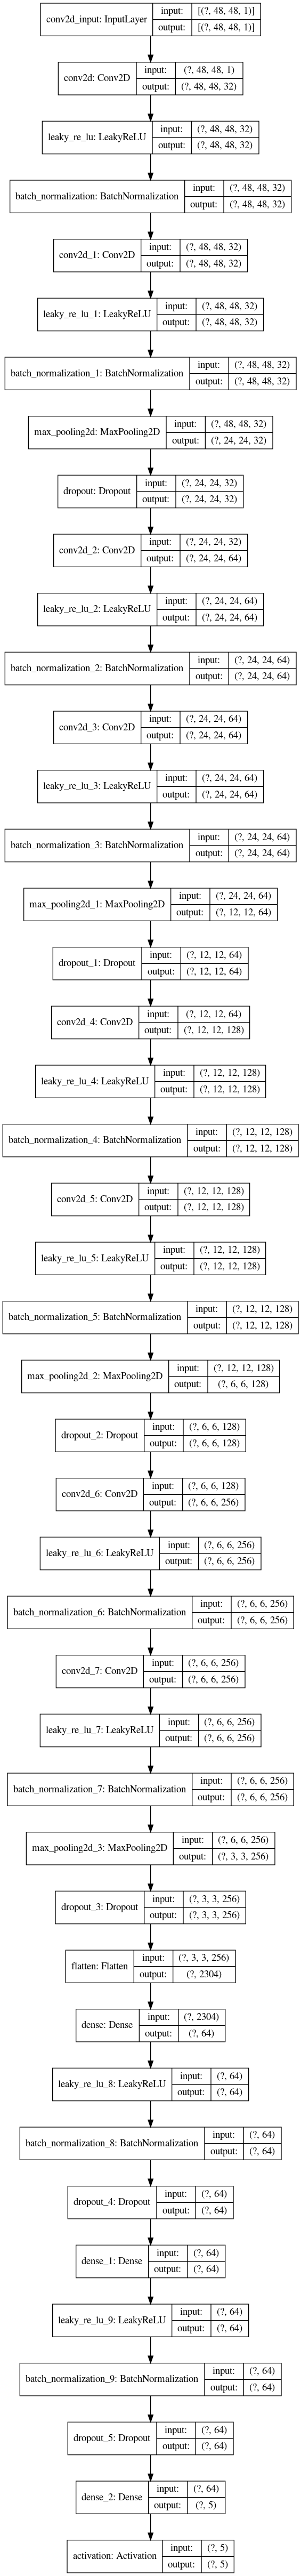

In [19]:
plot_model(model, to_file='CNNEmoDetLittleVgg.png', show_shapes=True)

In [20]:
model.save("CNNEmoDetLittleVgg.h5")

In [21]:
model_json = model.to_json()
with open("JCNNEmoDetLittleVgg.json", "w") as json_file:
    json_file.write(model_json)

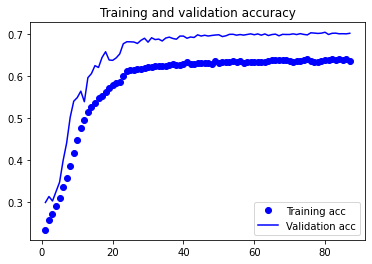

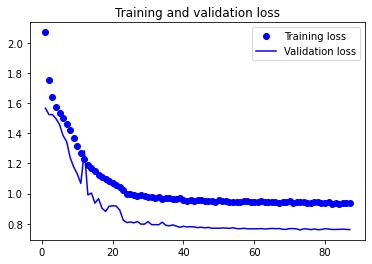

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
while True:
    x = input("---")